In [46]:
import sys
from pathlib import Path
import os

current_dir = Path.cwd()
project_dir = current_dir.parent
sys.path.append(str(project_dir))

from settings import ANNOTATED_ARTICLES_FILE

import pandas as pd
import matplotlib.pyplot as plt
import re
import seaborn as sns 

# Load the annotated articles from the JSON file
annotated_articles = pd.read_json(ANNOTATED_ARTICLES_FILE)


In [47]:
# Виділення країни з назви файлу
def extract_country_from_filename(filename):
    match = re.search(r'_([A-Z]{2})_', filename)
    if match:
        return match.group(1)
    return None

annotated_articles['country'] = annotated_articles['filename'].apply(extract_country_from_filename)

# Витягнення дати публікації з назви файлу та перетворення її на об'єкт datetime
annotated_articles['publication_date'] = pd.to_datetime(annotated_articles['filename'].str[:8], format='%Y%m%d')

# Додаємо умовний стовпець з URL (якщо це необхідно, інакше використовуйте filename)
annotated_articles['url'] = annotated_articles['filename']

# Фільтруємо статті, виключаючи Білорусь
filtered_articles = annotated_articles[annotated_articles['country'] != 'BY']

# Згруповуємо статті за країнами та розраховуємо середню тональність з помісячною частотою
country_sentiment_monthly = filtered_articles.groupby(['country', pd.Grouper(key='publication_date', freq='M')])['sentiment_ukraine'].mean().unstack()

# Виділяємо авторитетні медіа США та Великобританії
us_media = ['washingtonpost.com', 'cnn.com', 'nytimes.com']
gb_media = ['bbc.co.uk', 'theguardian.com', 'reuters.com']

# Фільтруємо статті для авторитетних медіа США та Великобританії
us_articles = filtered_articles[filtered_articles['url'].apply(lambda x: any(media in x for media in us_media))]
gb_articles = filtered_articles[filtered_articles['url'].apply(lambda x: any(media in x for media in gb_media))]

# Згруповуємо статті за медіа-категоріями та розраховуємо середню тональність з помісячною частотою
us_sentiment_monthly = us_articles.groupby(pd.Grouper(key='publication_date', freq='M'))['sentiment_ukraine'].mean()
gb_sentiment_monthly = gb_articles.groupby(pd.Grouper(key='publication_date', freq='M'))['sentiment_ukraine'].mean()

C:\Users\seshf\AppData\Local\Temp\ipykernel_20524\4088944980.py:20: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  country_sentiment_monthly = filtered_articles.groupby(['country', pd.Grouper(key='publication_date', freq='M')])['sentiment_ukraine'].mean().unstack()
C:\Users\seshf\AppData\Local\Temp\ipykernel_20524\4088944980.py:31: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  us_sentiment_monthly = us_articles.groupby(pd.Grouper(key='publication_date', freq='M'))['sentiment_ukraine'].mean()
C:\Users\seshf\AppData\Local\Temp\ipykernel_20524\4088944980.py:32: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  gb_sentiment_monthly = gb_articles.groupby(pd.Grouper(key='publication_date', freq='M'))['sentiment_ukraine'].mean()


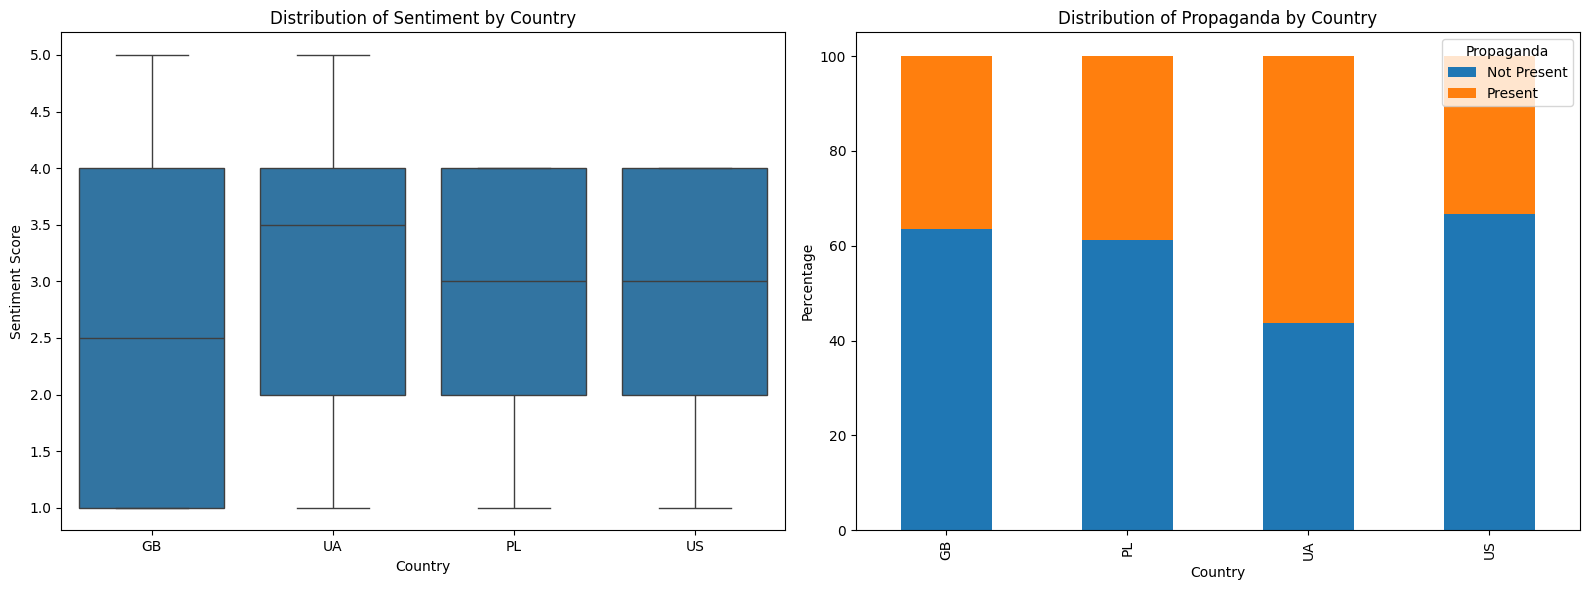

In [48]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))
sns.boxplot(x='country', y='sentiment_ukraine', data=filtered_articles, ax=ax1)
ax1.set_title('Distribution of Sentiment by Country')
ax1.set_xlabel('Country')
ax1.set_ylabel('Sentiment Score')

propaganda_counts = filtered_articles.groupby(['country', 'propaganda']).size().unstack()
propaganda_percentage = propaganda_counts.div(propaganda_counts.sum(axis=1), axis=0) * 100
propaganda_percentage.plot(kind='bar', stacked=True, ax=ax2)
ax2.set_title('Distribution of Propaganda by Country')
ax2.set_xlabel('Country')
ax2.set_ylabel('Percentage')
ax2.legend(title='Propaganda')

plt.tight_layout()
plt.show()

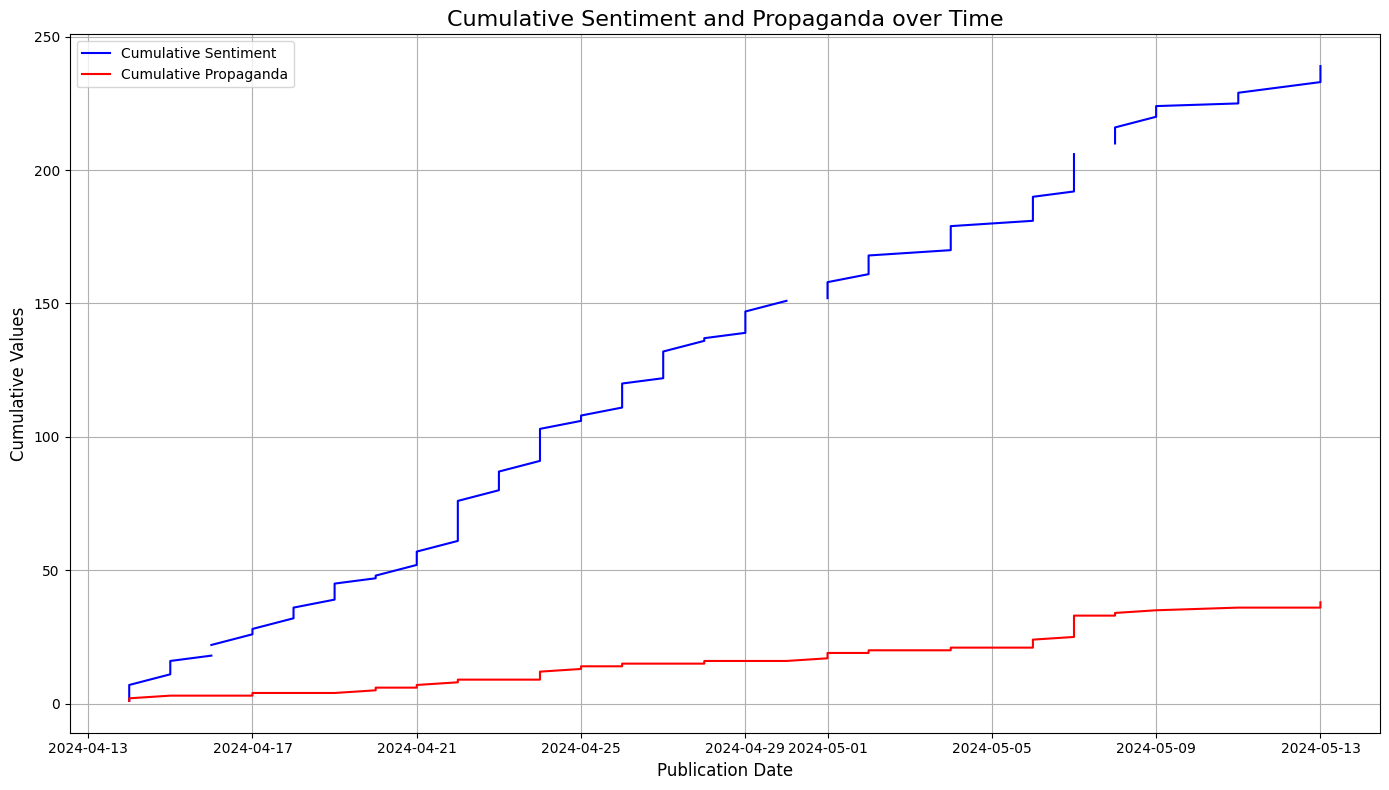

In [49]:
# Ensure 'propaganda' column is encoded as numeric
annotated_articles['propaganda'] = annotated_articles['propaganda'].apply(lambda x: 1 if x == 'Present' else 0)

# Cumulative sentiment and propaganda over time
annotated_articles['cumulative_sentiment'] = annotated_articles['sentiment_ukraine'].cumsum()
annotated_articles['cumulative_propaganda'] = annotated_articles['propaganda'].cumsum()

plt.figure(figsize=(14, 8))
plt.plot(annotated_articles['publication_date'], annotated_articles['cumulative_sentiment'], label='Cumulative Sentiment', color='blue')
plt.plot(annotated_articles['publication_date'], annotated_articles['cumulative_propaganda'], label='Cumulative Propaganda', color='red')
plt.xlabel('Publication Date', fontsize=12)
plt.ylabel('Cumulative Values', fontsize=12)
plt.title('Cumulative Sentiment and Propaganda over Time', fontsize=16)
plt.legend()
plt.tight_layout()
plt.grid(True)
plt.show()


C:\Users\seshf\AppData\Local\Temp\ipykernel_20524\2639899567.py:14: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  aspect_sentiments_df = aspect_sentiments_df.groupby([pd.Grouper(key='publication_date', freq='M'), 'aspect']).mean().reset_index()


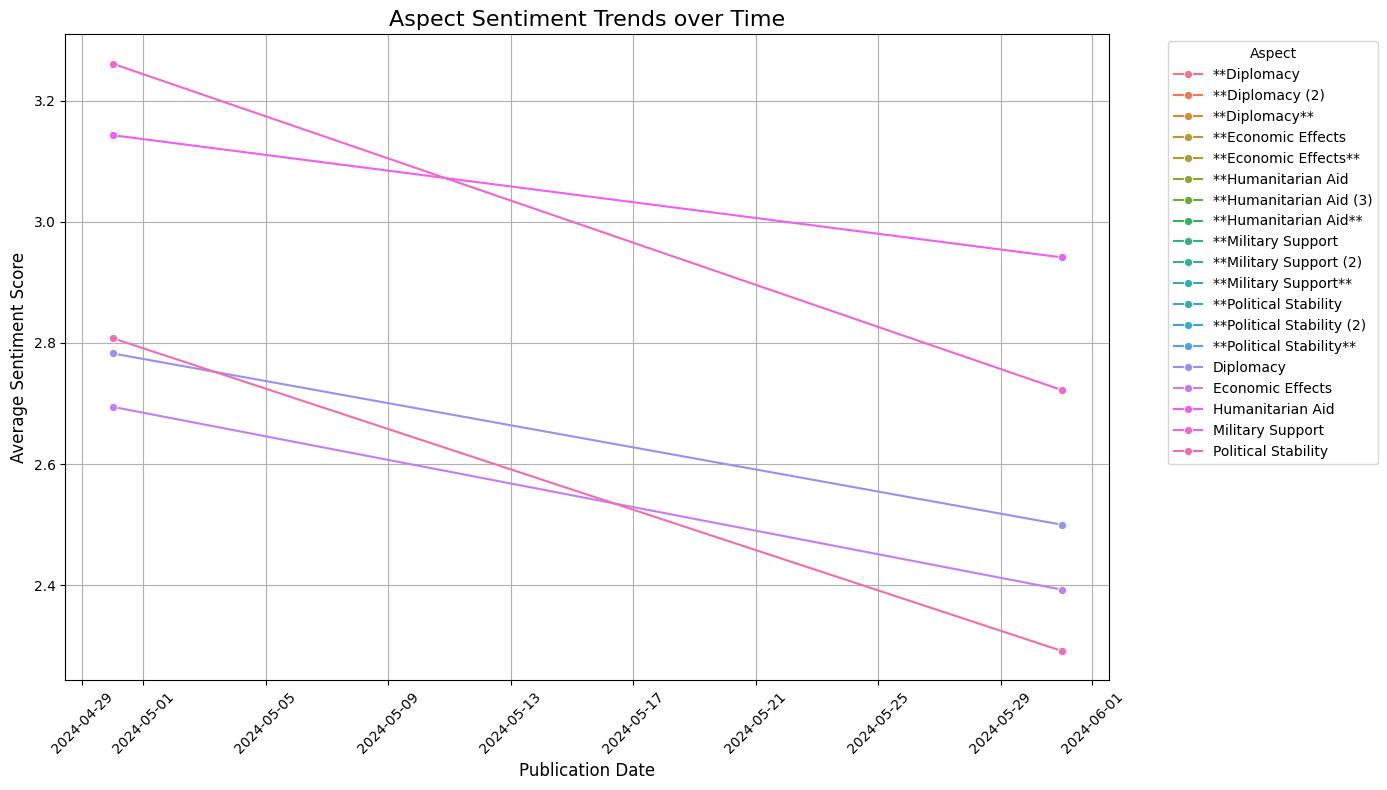

In [50]:

# Extract aspect sentiments
aspect_sentiments = []
for _, row in annotated_articles.iterrows():
    for aspect, score in row['aspects'].items():
        aspect_sentiments.append({
            'publication_date': row['publication_date'],
            'aspect': aspect,
            'sentiment_score': score
        })

aspect_sentiments_df = pd.DataFrame(aspect_sentiments)

# Group by aspect and calculate mean sentiment
aspect_sentiments_df = aspect_sentiments_df.groupby([pd.Grouper(key='publication_date', freq='M'), 'aspect']).mean().reset_index()

# Plot aspect sentiments over time
plt.figure(figsize=(14, 8))
sns.lineplot(data=aspect_sentiments_df, x='publication_date', y='sentiment_score', hue='aspect', marker='o')
plt.xlabel('Publication Date', fontsize=12)
plt.ylabel('Average Sentiment Score', fontsize=12)
plt.title('Aspect Sentiment Trends over Time', fontsize=16)
plt.xticks(rotation=45)
plt.legend(title='Aspect', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.grid(True)
plt.show()



C:\Users\seshf\AppData\Local\Temp\ipykernel_20524\47071901.py:3: FutureWarning: 

The `scale` parameter has been renamed and will be removed in v0.15.0. Pass `density_norm='width'` for the same effect.
  sns.violinplot(data=annotated_articles, x='country', y='sentiment_ukraine', inner='quartile', scale='width')


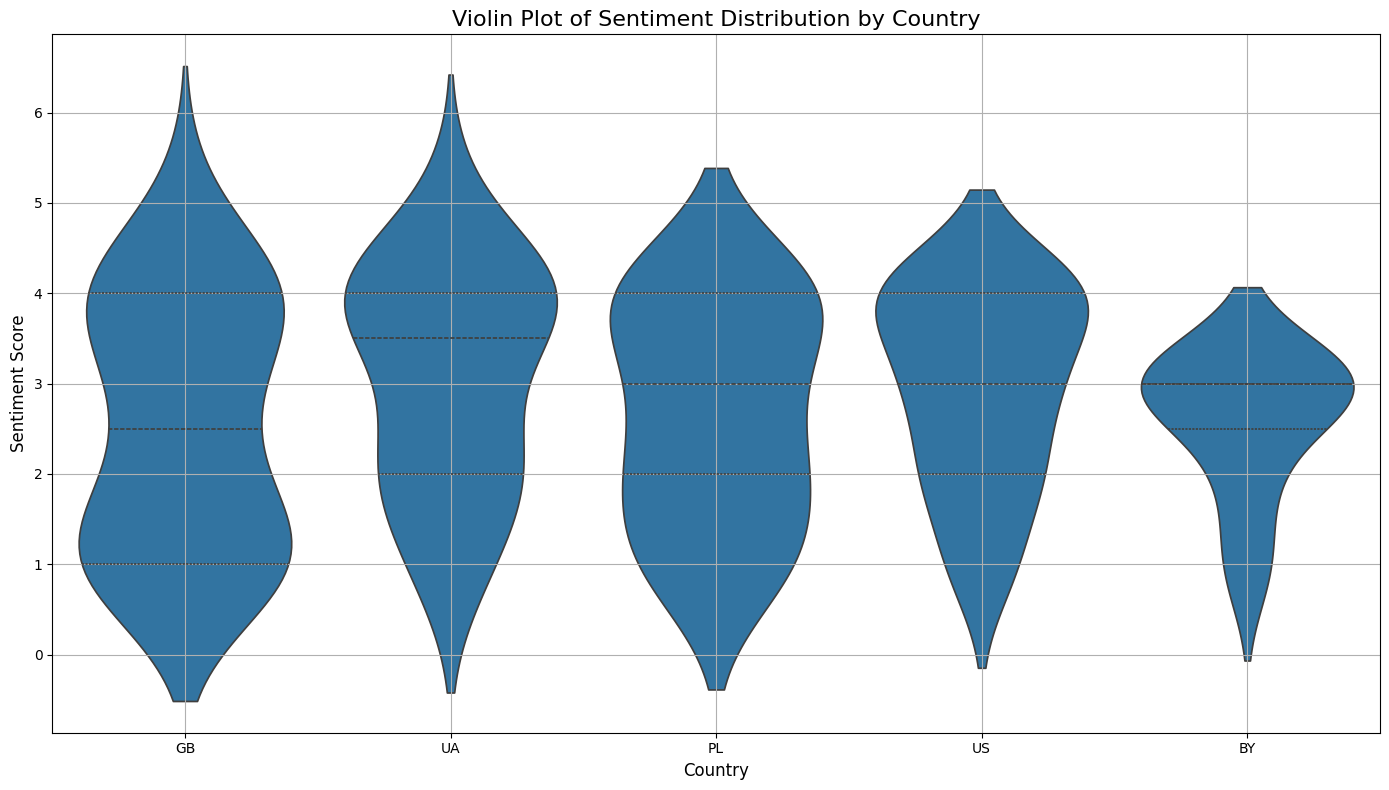

In [51]:
# Violin plot for sentiment distribution by country
plt.figure(figsize=(14, 8))
sns.violinplot(data=annotated_articles, x='country', y='sentiment_ukraine', inner='quartile', scale='width')
plt.title('Violin Plot of Sentiment Distribution by Country', fontsize=16)
plt.xlabel('Country', fontsize=12)
plt.ylabel('Sentiment Score', fontsize=12)
plt.grid(True)
plt.tight_layout()
plt.show()


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


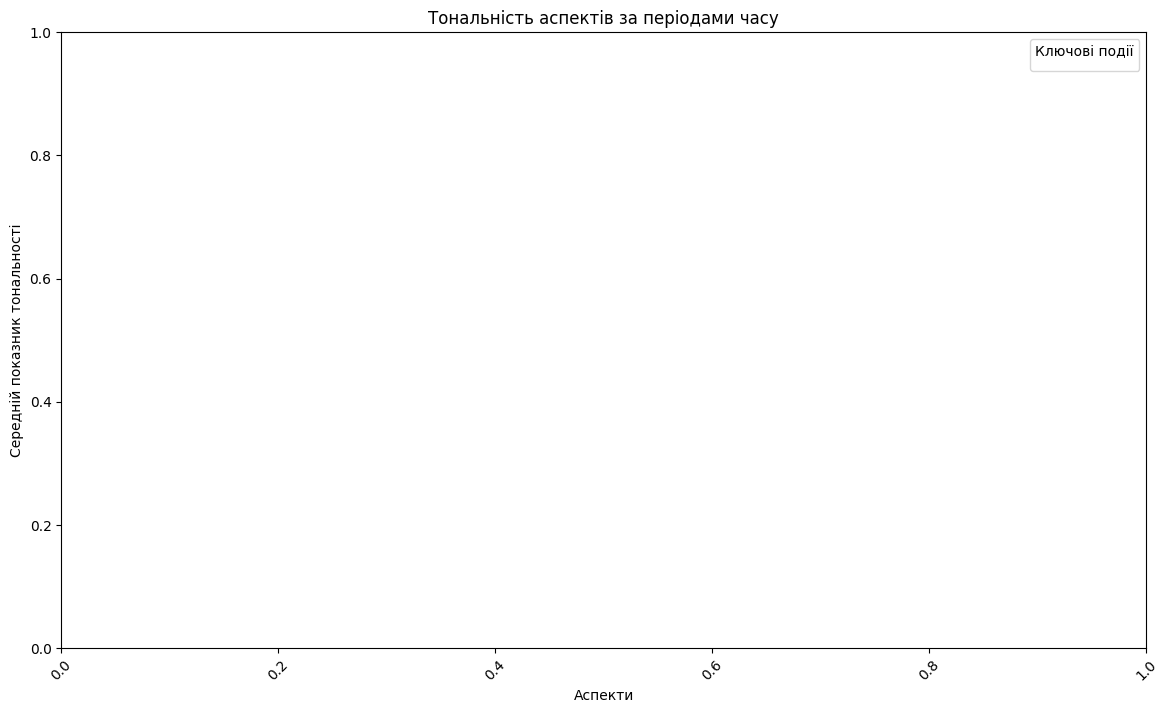

In [45]:
# Ключові події
key_events = {
    '2022-02-24': 'Start of Russian Invasion',
    '2022-04-02': 'Bucha Massacre Discovered',
    '2022-09-06': 'Ukrainian Counteroffensive in Kharkiv',
    '2023-02-20': 'Russian Offensive in Eastern Ukraine',
    '2023-07-01': 'Ukraine Joins NATO',
    '2022-03-15': 'Sanctions Law Against Russia',
    '2022-06-26': 'G7 Leaders Meeting on Ukraine',
    '2023-03-10': 'Military Aid Agreement Signed'
}

plt.figure(figsize=(14, 8))

# Аналіз аспектів для кожного ключового моменту війни
for date, event in key_events.items():
    # Визначаємо початок і кінець періоду (6 місяців після події)
    start_date = pd.to_datetime(date)
    end_date = start_date + pd.DateOffset(months=6)
    
    # Фільтрація даних за періодом
    period_data = annotated_articles[(annotated_articles['publication_date'] >= start_date) & 
                                     (annotated_articles['publication_date'] < end_date)]
    
    # Групування даних за аспектами
    aspect_sentiments_period = period_data.groupby('aspects')['sentiment_ukraine'].mean().reset_index()
    
    # Візуалізація
    sns.barplot(data=aspect_sentiments_period, x='aspects', y='sentiment_ukraine', label=event)

plt.xlabel('Аспекти')
plt.ylabel('Середній показник тональності')
plt.title('Тональність аспектів за періодами часу')
plt.legend(title='Ключові події')
plt.xticks(rotation=45)
plt.show()
